# N-BEATS Exploration

N-BEATS trains by alternating between the future values and reconstructing the past values so it backcasts. This leads to a minimisation in error between its predictions and actual data, resulting in a high forecasting ability.

### Advantages 

N-BEATS is modular, its architecture allows multiple blocks to be configured in ways that suit different applications, additionally, it is designed tohandle a diverse array of time series data, making it inherintly generalisable. 


## Importing Libraries

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, Dataset
from nbeats_pytorch.model import NBeatsNet
from sklearn.metrics import mean_squared_error, mean_absolute_error


## Dataset Creation

In [35]:
# Creating a synthetic temperature dataset 
def create_temp_data(length, num_samples):
    np.random.seed(0)
    x = np.linspace(0, length, num_samples)
    seasonal = 10 + 10 * np.sin(2 * np.pi * x / 365)
    noise = np.random.normal(0, 2, num_samples)
    y = seasonal + noise
    return x, y

In [36]:
x, y = create_temp_data(365, 3650)

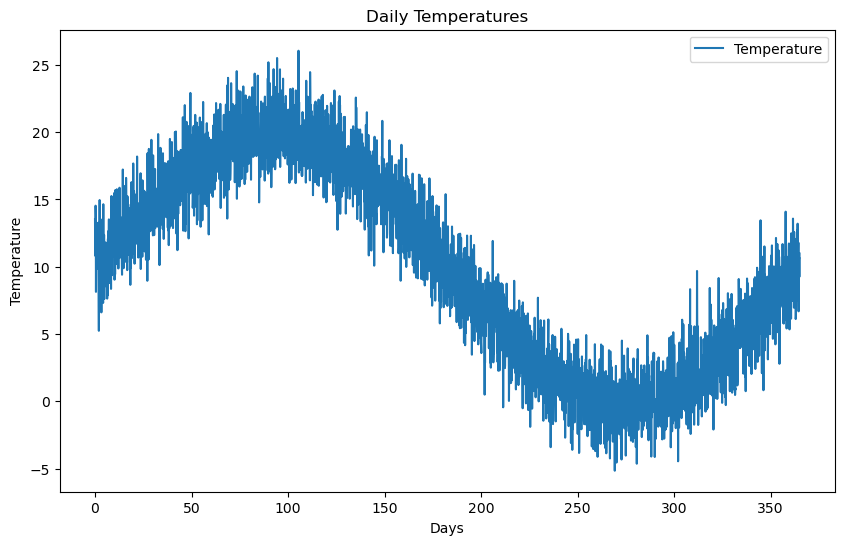

In [37]:
#Plotting the dataset
#The plot shows 365 days of temperature varied including noise

plt.figure(figsize=(10, 6))
plt.plot(x, y, label = "Temperature")
plt.xlabel("Days")
plt.ylabel("Temperature")
plt.title("Daily Temperatures")
plt.legend()
plt.show()


## Pytorch Dataset

In [38]:
# Setting parameters

backcast_length = 30
forecast_length = 7

In [39]:
#Defining the Pytorch Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, data, backcast_length, forecast_length):
        self.data = data
        self.backcast_length = backcast_length
        self.forecast_length = forecast_length

    def __len__(self):
        return len(self.data) - self.backcast_length - self.forecast_length
    
    def __getitem__(self, index): 
        x = self.data[index : index + self.backcast_length]
        y = self.data[index + self.backcast_length : index + self.backcast_length + self.forecast_length]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

In [40]:
dataset = TimeSeriesDataset(y, backcast_length, forecast_length)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

## NBEATS Model

In [41]:
device = 'cpu'

In [42]:
#Defining the N-BEATS Model
model = NBeatsNet(
    device = device,
    stack_types=(NBeatsNet.GENERIC_BLOCK, NBeatsNet.GENERIC_BLOCK),
    #learning_rate=1e-3,
    backcast_length = backcast_length,
    forecast_length = forecast_length,
    hidden_layer_units=128).to(device)

| N-Beats
| --  Stack Generic (#0) (share_weights_in_stack=False)
     | -- GenericBlock(units=128, thetas_dim=4, backcast_length=30, forecast_length=7, share_thetas=False) at @2725409528448
     | -- GenericBlock(units=128, thetas_dim=4, backcast_length=30, forecast_length=7, share_thetas=False) at @2725409337312
     | -- GenericBlock(units=128, thetas_dim=4, backcast_length=30, forecast_length=7, share_thetas=False) at @2725409340000
| --  Stack Generic (#1) (share_weights_in_stack=False)
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=30, forecast_length=7, share_thetas=False) at @2725394785584
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=30, forecast_length=7, share_thetas=False) at @2725409167040
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=30, forecast_length=7, share_thetas=False) at @2725409169344


In [43]:
#Defining validation loss
criterion = torch.nn.MSELoss()

#Defining Optimizer
optimizer = torch.optim.Adam(model.parameters())

In [44]:
#Training the model
epochs = 80

for epoch in range(epochs):
    for x_batch, y_batch in dataloader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad() #set gradients to zero before backpropagation
        backcast, forecast = model(x_batch)
        loss = criterion(forecast, y_batch)
        loss.backward()
        optimizer.step() #Reevaluates the model and returns the loss

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}")

Epoch 10/80, Loss: 3.5447914600372314
Epoch 20/80, Loss: 2.872987747192383
Epoch 30/80, Loss: 2.5775983333587646
Epoch 40/80, Loss: 1.8992505073547363
Epoch 50/80, Loss: 1.4315483570098877
Epoch 60/80, Loss: 0.6008116006851196
Epoch 70/80, Loss: 0.5386635661125183
Epoch 80/80, Loss: 0.25114768743515015


In [45]:
"""
# Calculate MSE and MAE
mse = mean_squared_error(y_batch.flatten(), forecast.flatten())
mae = mean_absolute_error(y_batch.flatten(), forecast.flatten())

print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')"""


"\n# Calculate MSE and MAE\nmse = mean_squared_error(y_batch.flatten(), forecast.flatten())\nmae = mean_absolute_error(y_batch.flatten(), forecast.flatten())\n\nprint(f'Mean Squared Error (MSE): {mse}')\nprint(f'Mean Absolute Error (MAE): {mae}')"

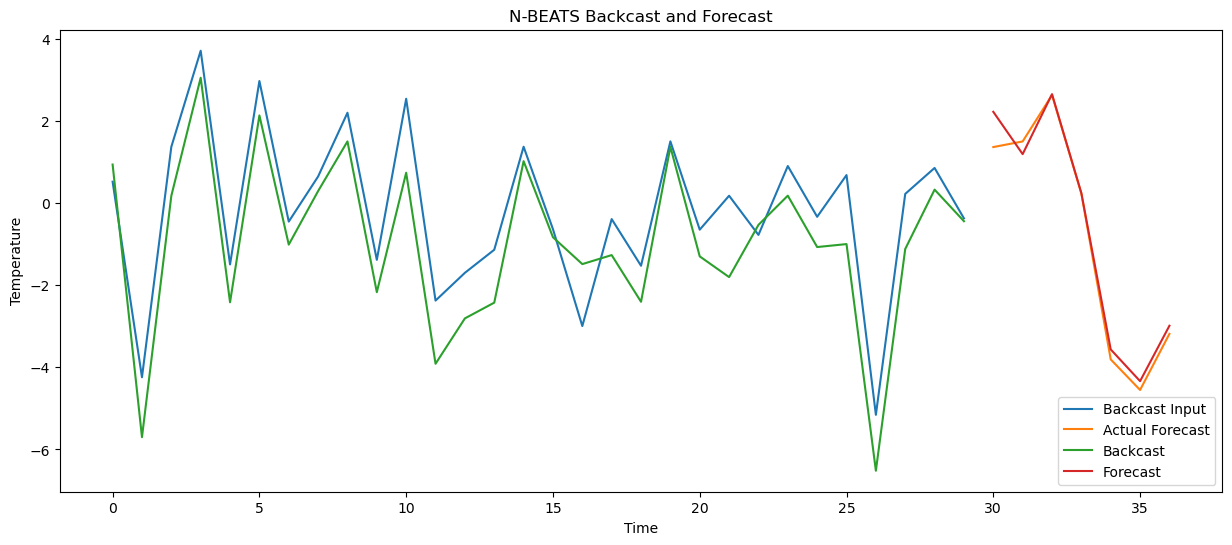

In [46]:
#Visualizing Backcast, Forecast, and Model Weights
model.eval()
x_batch, y_batch = next(iter(dataloader))
x_batch, y_batch = x_batch.to(device), y_batch.to(device)

with torch.no_grad():
    backcast, forecast = model(x_batch)

# Convert to numpy for plotting
backcast = backcast.cpu().numpy()
forecast = forecast.cpu().numpy()
x_batch = x_batch.cpu().numpy()
y_batch = y_batch.cpu().numpy()

# Plot results
plt.figure(figsize=(15, 6))
plt.plot(range(backcast_length), x_batch[0], label='Backcast Input')
plt.plot(range(backcast_length, backcast_length + forecast_length), y_batch[0], label='Actual Forecast')
plt.plot(range(backcast_length), backcast[0], label='Backcast')
plt.plot(range(backcast_length, backcast_length + forecast_length), forecast[0], label='Forecast')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.title('N-BEATS Backcast and Forecast')
plt.legend()
plt.show()

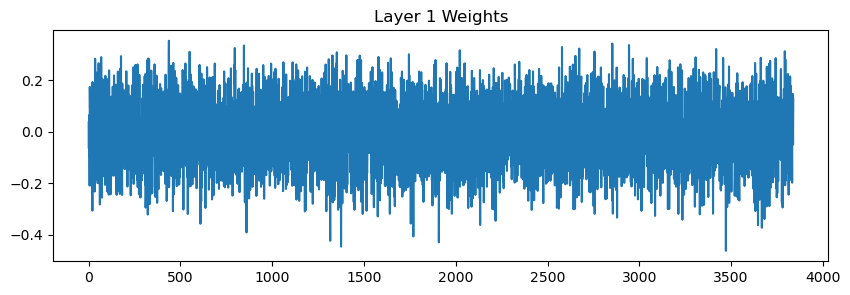

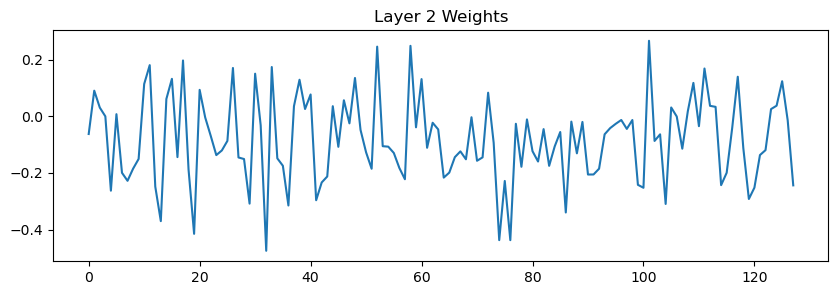

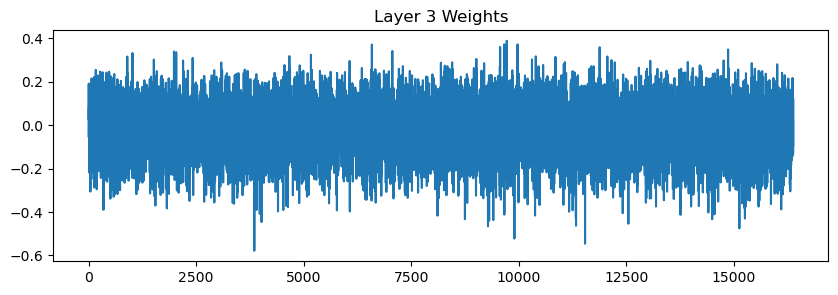

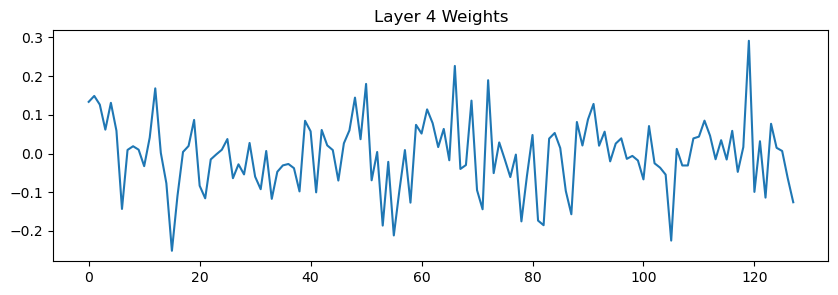

In [47]:
# Visualize model weights
weights = [param.cpu().data.numpy() for param in model.parameters()]

# Plot weights of the first few layers for illustration
for i, weight in enumerate(weights[:4]):
    plt.figure(figsize=(10, 3))
    plt.plot(weight.flatten())
    plt.title(f'Layer {i+1} Weights')
    plt.show()